---
---

# 1. Setup

---
---

### Import packages for clustering the data

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

### Import packages for plotting

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

### General Imports

In [ ]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import ast
import plotly.graph_objects as go
import random

from tqdm.auto import tqdm
from sklearn.metrics.pairwise import cosine_similarity

### Remove warnings from output

In [ ]:
pd.options.mode.chained_assignment = None

### Mount the Drive

In [ ]:
drive.mount("/content/drive")#, force_remount=True)

Mounted at /content/drive


In [ ]:
os.chdir("drive/MyDrive/ca4015_assignment4/data")

---
---

# 2. Read in the Data

---
---

We read in the processed data here. This contains the original data along with the aditional data scraped using Spotify's API. All of this data will be used throughout this notebook


## Read the processed data into a pandas dataframe

In [ ]:
df = pd.read_csv(open(os.path.join("processed_data", 'original_and_spotify_data (1).csv')))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.shape

(2269518, 12)

In [ ]:
df.head()

,userID,artistID,artistWeight,friendID,artistName,tagID,timestamp,tagValue,spotifyName,imageUrl,genres,spotifyUrl
0,2,51,13883.0,275.0,Duran Duran,NaN,NaN,NaN,Duran Duran,https://i.scdn.co/image/2e6d5966dafa119f4a75e7...,"['dance rock', 'new romantic', 'new wave', 'ne...",https://open.spotify.com/artist/0lZoBs4Pzo7R89...
1,2,51,13883.0,428.0,Duran Duran,NaN,NaN,NaN,Duran Duran,https://i.scdn.co/image/2e6d5966dafa119f4a75e7...,"['dance rock', 'new romantic', 'new wave', 'ne...",https://open.spotify.com/artist/0lZoBs4Pzo7R89...
2,2,51,13883.0,515.0,Duran Duran,NaN,NaN,NaN,Duran Duran,https://i.scdn.co/image/2e6d5966dafa119f4a75e7...,"['dance rock', 'new romantic', 'new wave', 'ne...",https://open.spotify.com/artist/0lZoBs4Pzo7R89...
3,2,51,13883.0,761.0,Duran Duran,NaN,NaN,NaN,Duran Duran,https://i.scdn.co/image/2e6d5966dafa119f4a75e7...,"['dance rock', 'new romantic', 'new wave', 'ne...",https://open.spotify.com/artist/0lZoBs4Pzo7R89...
4,2,51,13883.0,831.0,Duran Duran,NaN,NaN,NaN,Duran Duran,https://i.scdn.co/image/2e6d5966dafa119f4a75e7...,"['dance rock', 'new romantic', 'new wave', 'ne...",https://open.spotify.com/artist/0lZoBs4Pzo7R89...


In [ ]:
df.describe()

,userID,artistID,artistWeight,friendID,tagID
count,2.269518e+06,2.269518e+06,2.156397e+06,2.156397e+06,1.301175e+06
mean,9.814908e+02,2.961728e+03,2.065768e+03,9.907670e+02,1.602324e+03
std,6.167526e+02,4.373358e+03,8.791553e+03,6.059923e+02,2.864083e+03
min,2.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00
25%,4.130000e+02,3.110000e+02,1.700000e+02,4.360000e+02,8.100000e+01
50%,9.510000e+02,9.170000e+02,4.480000e+02,9.760000e+02,2.850000e+02
75%,1.519000e+03,3.393000e+03,1.215000e+03,1.511000e+03,1.351000e+03
max,2.100000e+03,1.874500e+04,3.526980e+05,2.100000e+03,1.264700e+04


## Read in subset of this processed data relating to the artists for plotting the recommendations

In [ ]:
artists = df[["artistID", "artistName", "imageUrl", "spotifyUrl", "genres"]] \
.drop_duplicates().dropna(subset=["artistName"]) \
.sort_values("artistID").reset_index(drop=True)

artists["genres"] = artists["genres"].apply(ast.literal_eval)
artists["genre"] = artists["genres"].apply(lambda x: x[0] if len(x) > 0 else None)

In [ ]:
artists.head()

,artistID,artistName,imageUrl,spotifyUrl,genres,genre
0,1,MALICE MIZER,NaN,NaN,[],None
1,2,Diary of Dreams,https://i.scdn.co/image/d1541238b711b8ca7aca43...,https://open.spotify.com/artist/1tg5jMp8FFjVqj...,"[dark wave, ebm, electro-industrial, ethereal ...",dark wave
2,3,Carpathian Forest,https://i.scdn.co/image/ab67616d0000b273e5e56d...,https://open.spotify.com/artist/0sFntmE9T1tiF6...,"[black metal, dark black metal, metal, norwegi...",black metal
3,4,Moi dix Mois,NaN,NaN,[],None
4,5,Bella Morte,https://i.scdn.co/image/24df6d7abf75759f89bda2...,https://open.spotify.com/artist/2SyimynlSU0Oii...,"[dark wave, ethereal wave, gothic rock]",dark wave


## Setup the data for clustering

This processed contains a lot of different features but not all of these are needed for the clustering and also it is needed in a different format. As a result we must re-format the table here and create a table specific for the clustering

#### Get a subset of the needed columns

In [ ]:
subset_columns_df = df["userID", "artistName", "artistWeight"].drop_duplicates()

In [ ]:
subset_columns_df.shape

(94202, 3)

In [ ]:
subset_columns_df.head()

,userID,artistWeight,artistName
0,2,13883.0,Duran Duran
13,4,228.0,Duran Duran
33,27,85.0,Duran Duran
37,28,10.0,Duran Duran
38,62,528.0,Duran Duran


#### Standardise the artistWeight column

In [ ]:
print("The 'artistWeight' column has a minimum value of {} and a amaximum value of {}".format(round(min(subset_columns_df["artistWeight"]), 3), round(max(subset_columns_df["artistWeight"]), 3)))

The 'artistWeight' column has a minimum value of 1.0 and a amaximum value of 352698.0


In [ ]:
normalised_df = subset_columns_df.copy()
normalised_df["artistWeight"] = (subset_columns_df["artistWeight"] - subset_columns_df["artistWeight"].mean()) / subset_columns_df["artistWeight"].std()

In [ ]:
print("The normalised 'artistWeight' column has a minimum value of {} and a amaximum value of {}".format(round(min(normalised_df["artistWeight"]), 3), round(max(normalised_df["artistWeight"]), 3)))

The normalised 'artistWeight' column has a minimum value of -0.198 and a amaximum value of 93.821


In [ ]:
normalised_df.head()

,userID,artistWeight,artistName
0,2,3.502167,Duran Duran
13,4,-0.137883,Duran Duran
33,27,-0.176003,Duran Duran
37,28,-0.195996,Duran Duran
38,62,-0.057911,Duran Duran


#### Pivot the table to get the right format for clustering

In [ ]:
pivoted_df = pd.pivot_table(normalised_df, values="artistWeight", index="userID", columns="artistName")

In [ ]:
pivoted_df.shape

(1892, 17632)

In [ ]:
pivoted_df.head()

artistName,!!!,!DISTAIN,!deladap,#####,#2 Orchestra,$lick,$lick feat. Six-Fo,(1962-1966),(Pre) Kingdom,(We Are) Performance,(hed) Planet Earth,(sic)monic,*NSYNC,+44,+\-,-123 min.,-OZ-,-t de sangre,...And The Earth Swarmed With Them,...And You Will Know Us by the Trail of Dead,.38 Special,.crrust,06 Children Of The Cross,08001,1-800-ZOMBIE,10 Years,10-20 БЕЗ ВЫХОДНЫХ,100 Bitches,1000names,100DEADRABBITS!!!,100blumen,100dBs,10cc,11.43,110,112,1125,12 Rounds,12 Stones,120 Days,...,박정현,반야,배치기,백지영,비,빅뱅,샤이니,샤이니 (SHINee),서태지,소녀시대,소녀시대 ＆ 2PM,손담비,송지은,승리,시크릿,신화,아웃사이더,아이비,애프터 스쿨(After School),엠블랙(MBLAQ),원더걸스,윤하,이박사,이수영(여),이수영(여);,이정현,이효리,장근석,제빵왕,태양,티아라,현아,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ,ｂｏｏｇｉｅｍａｎ,ｂｏｒｎ,ｍａｃｈｉｎｅ
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Replace the 'Nan' values

In [ ]:
cluster_df = pivoted_df.replace(float("nan"), -0.5)

In [ ]:
cluster_df.head()

artistName,!!!,!DISTAIN,!deladap,#####,#2 Orchestra,$lick,$lick feat. Six-Fo,(1962-1966),(Pre) Kingdom,(We Are) Performance,(hed) Planet Earth,(sic)monic,*NSYNC,+44,+\-,-123 min.,-OZ-,-t de sangre,...And The Earth Swarmed With Them,...And You Will Know Us by the Trail of Dead,.38 Special,.crrust,06 Children Of The Cross,08001,1-800-ZOMBIE,10 Years,10-20 БЕЗ ВЫХОДНЫХ,100 Bitches,1000names,100DEADRABBITS!!!,100blumen,100dBs,10cc,11.43,110,112,1125,12 Rounds,12 Stones,120 Days,...,박정현,반야,배치기,백지영,비,빅뱅,샤이니,샤이니 (SHINee),서태지,소녀시대,소녀시대 ＆ 2PM,손담비,송지은,승리,시크릿,신화,아웃사이더,아이비,애프터 스쿨(After School),엠블랙(MBLAQ),원더걸스,윤하,이박사,이수영(여),이수영(여);,이정현,이효리,장근석,제빵왕,태양,티아라,현아,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ,ｂｏｏｇｉｅｍａｎ,ｂｏｒｎ,ｍａｃｈｉｎｅ
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
3,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
4,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
6,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5


---
---

# 3. Experiment with the number of clusters

---
---

Our approach with this recommender system is to cluster the users into similar groups based on the artists they listen to and then to recommend artists to a user based on these clusters.

For this to work however, we must first find the optimal number of clusters.
We want to find a number small enough that all of a given user's music preferences can be tailored to and that each cluster isn't just a small subset of music. However, we also want to have the number of clusters big enough that there is not too much variation within the clusters. If there was too few clusters, that means a lot of different musical tastes are being captured by the same cluster.

As a result, we must test out a few different algorithms and cluster numbers to see if we can pinpoint the optimal configuration.

#### Create the functions for this experimentation

This code was taken directly from Nathan's Assignment 1. This code was perfect for experimenting with different algorithms and displaying the optimal number of clusters

In [ ]:
def get_silhouette_scores_list(scaled_train_df, model_function, num_clusters_to_iter, random_seed_val, affinity_value=None):
    
    # Initialise empty list for the Silhouette Scores for KMeans model
    s_scores = []

    # Running algorithm and calculating Silhouette Score
    for k in tqdm(num_clusters_to_iter):

        # Building the clustering model
        if affinity_value:
            model = model_function(n_clusters = k, random_state = random_seed_val, affinity = affinity_value)
            
        else:
            model = model_function(n_clusters = k, random_state = random_seed_val)
        
        # Training the model and storing the predicted cluster labels
        labels = model.fit_predict(scaled_train_df)

        # Evaluating the performance and adding score to list
        s_scores.append(silhouette_score(scaled_train_df, labels))

    return s_scores

In [ ]:
def analyse_silhouette_scores_to_get_optimal_cluster_number(silhouette_score_list, num_clusters_to_iter):

    # Analyse these results to see the optimal cluster number
    max_silhouette_score = max(silhouette_score_list)
    index_max_score = silhouette_score_list.index(max_silhouette_score)

    print("The maximum Silhouette Score was", max_silhouette_score)
    print("This score is achieved by running", num_clusters_to_iter[index_max_score], "clusters")

    # plot the silhoutte scores against the cluster numbers
    plt.plot(num_clusters_to_iter, silhouette_score_list, 'bx-')
    plt.xlabel('# Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette scores for the model accross a different number of clusters')
    plt.show()

    # Output a table of the score for each cluster
    cluster_nd_score_df = pd.DataFrame(silhouette_score_list, index=num_clusters_to_iter).rename(columns={0: "Silhouette Score"})
    cluster_nd_score_df.index.name = "# Clusters"
    
    return cluster_nd_score_df.T

#### Experiment with the different algorithms

To determine which algorithm is more appropriate to the dataset, we will measure their performance using the Silhouette Coefficient. The Silhouette Coefficient of a data point quantifies how similar a data point is to its own cluster compared to other clusters. We will use the mean Silhouette Coefficient across all data points to compare the performace of algorithms.

The Silhouette Coefficient for a particular data point is calculated by the below formula:

$$s = \frac{b - a}{max(a, b)}$$
Where:

a is the mean distance between a data point and all other points in the same cluster. (the mean intra-cluster distance)
b is the mean distance between a data point and all other points in the next nearest cluster. (the mean nearest-cluster distance)

The Silhouette score can assume values between -1 and 1. Scores closer to -1 indicate incorrect clustering whereas those nearer to +1 indicate highly dense clustering. Scores around zero are indicative of overlapping clusters.

Therefore, a good indicator of what clustering algorithm to choose would be the one whose mean Silhouette Coefficient is nearest to 1.

In [ ]:
random_seed_val = 0

The first algorithm we will test is Kmeans. We will use this as it is the most popular clustering technique and can be quite good in different situations.

Also in this case, we think that similar users will often be congregated together in simple circular structures.

We will first look at this with a smaller number of clusters to see how it fairs.

##### *Kmeans*



In [ ]:
num_clusters_to_iter_km_10 = range(2, 12)
s_scores_km_10 = get_silhouette_scores_list(cluster_df, KMeans, num_clusters_to_iter_km_10, random_seed_val)

The maximum Silhouette Score was 0.9173986639424402
This score is achieved by running 2 clusters


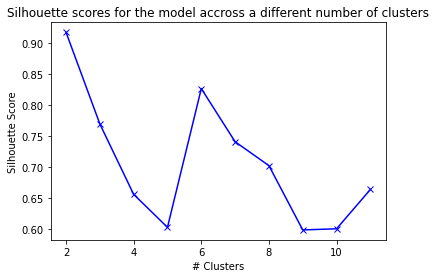

# Clusters,2,3,4,5,6,7,8,9,10,11
Silhouette Score,0.917399,0.769723,0.656252,0.603186,0.826645,0.741032,0.702524,0.59899,0.600788,0.664146


In [ ]:
cluster_nd_score_km_10_df = analyse_silhouette_scores_to_get_optimal_cluster_number(s_scores_km_10, num_clusters_to_iter_km_10)
cluster_nd_score_km_10_df

We will now also have a look at different clustering algorithms to see how they compared to these results.
The next clustering technique on our radar was spectral clustering. While this algorithm used with affinity='rbf' was too time intensive for us, using affinity='nearest_neighbors' was much better.

##### *Spectral Clustering with affinity='nearest_neighbors'*

In [ ]:
num_clusters_to_iter_nn = range(2, 12)
s_scores_nn = get_silhouette_scores_list(cluster_df, SpectralClustering, num_clusters_to_iter_nn, random_seed_val, 'nearest_neighbors')

The maximum Silhouette Score was 0.40294195640585106
This score is achieved by running 3 clusters


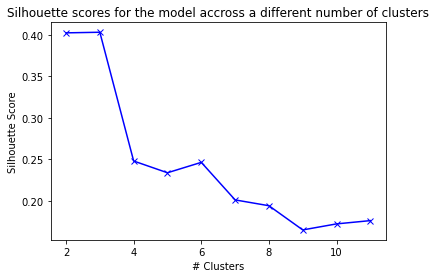

# Clusters,2,3,4,5,6,7,8,9,10,11
Silhouette Score,0.402206,0.402942,0.247846,0.233701,0.246234,0.201009,0.193993,0.164862,0.172122,0.176061


In [ ]:
cluster_nd_score_nn_df = analyse_silhouette_scores_to_get_optimal_cluster_number(s_scores_nn, num_clusters_to_iter_nn)
cluster_nd_score_nn_df

This algorithm did not fair so well when it came to the silhouette score metric we were using with its maximum value across this range being less than half that of the kmeans algorithm.

As a result of this, we were happy to say that the kmeans algorithm was a better clustering algorithm than the spectral clustering algorithm in this case.

While we knew having only a maximum of 12 clusters in these tests was not sufficient for our purpose as this gives too much diversity of music taste in each cluster, these algorithms take quite a long time to test so we deicded to test our approach on the smaller sample and then scale this up.

Another clustering algorithm type we wanted to test out was auto-regressive clustering methods. These methods are able to cluster more complex forms of data. One particular type of these algorithms is DBSCAN. This algorithm was one of the quickest auto-regressive clustering algorithms that we saw so we decided to test it as well.

##### *DBSCAN*

The below image is an example taken from the Ski-kit learn website (https://scikit-learn.org/stable/modules/clustering.html) that shows the complex data structures that DBSCAN can cluster and in what time frame it can do this.

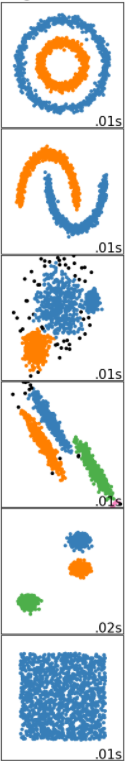

As you can see, it is able to segregate out complex cluster structures from the datapoints and that it does this pretty quickly.

As a result of these findings, we will attempt to run this algorihtm to compare it results to that of the our other clustering algorithms above.

When running this algorithm, we configured the maximum distance between two samples for one to be considered as in the neighborhood of the other to be '3'. We figured this was large enough to ensure that close points were considered neighbours.
We also set the minimum custer size as 2. This was to ensure that this number was big enough so that no cluster just had one single point and was small enough that it didn't exclude small clusters of points.

In [ ]:
dbscan_clustering = DBSCAN(eps=3, min_samples=2).fit(np.array(cluster_df))

In [ ]:
cluster_col = pd.DataFrame(dbscan_clustering.labels_, columns=["cluster"])

In [ ]:
cluster_col.value_counts()

cluster
-1         948
 0         936
 2           6
 1           2
dtype: int64

As you can see from the above, disapointingly, this algorithm only returned 4 clusters. This was not enough for our purpose so we imediately have to discount this clustering method.

From comparison of the two of the other algorihtms (kmeans and spectral clustering), there was a clear better algorithm here for us.

We hypothesised that as we increased the number of clusters, the value for the silhoette score would decrease so having the much higher silhouette scores at the start meant we could also get higher scores as we increased the number of clusters.

As a result of this smaller test, we concluded Kmeans was the better algorithm for our case. We decided to run this then on a larger set of up to 250 clusters to see how accurate it would be on large amounts.

##### *Kmeans*



Note: the below progress graph says 72% but in fact this was run fully though. The results of this full run can be seen in the below graph

In [ ]:
num_clusters_to_iter_km = range(2, 250, 10)
s_scores_km = get_silhouette_scores_list(cluster_df, KMeans, num_clusters_to_iter_km, random_seed_val)

The maximum Silhouette Score was 0.9173986639424402
This score is achieved by running 2 clusters


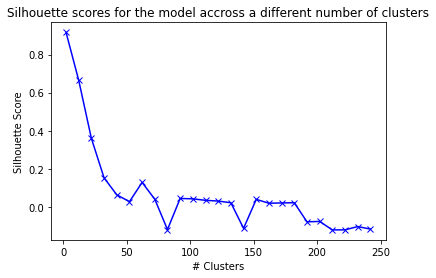

# Clusters,2,12,22,32,42,52,62,72,82,92,102,112,122,132,142,152,162,172,182,192,202,212,222,232,242
Silhouette Score,0.917399,0.665053,0.35982,0.152455,0.063421,0.027222,0.128291,0.04011,-0.119317,0.044134,0.042102,0.034273,0.030334,0.021637,-0.112893,0.039323,0.01904,0.020572,0.02156,-0.078629,-0.076561,-0.12115,-0.12082,-0.103636,-0.116693


In [ ]:
cluster_nd_score_km_df = analyse_silhouette_scores_to_get_optimal_cluster_number(s_scores_km, num_clusters_to_iter_km)
cluster_nd_score_km_df

From analysis of this graph, we had a tough choice to make.
This choice boiled down to a compromise between higher accuracy scores and larger number os cluster.

We decided to go with ***62*** clusters in the end as from the graph, this cluster value had the 5th highest silhouette score of all the clusters from 2-252 and it also seemed suficiently large for our purpose.

---
---

# 4. Cluster the users based on the artists and their weighting

---
---

Here we will take the experimantation from above into account to configure our clustering model.
These configurations are using ***Kmeans*** to cluster the data into ***62 clusters***

### Cluster the users by the artists and their weightings

In [ ]:
final_num_clusters = 62

In [ ]:
kmeans_model = KMeans(n_clusters=final_num_clusters, random_state=random_seed_val)

In [ ]:
cluster_labels_array = kmeans_model.fit_predict(cluster_df)

In [ ]:
cluster_labels_df = pd.DataFrame(cluster_labels_array, columns=["cluster"])

In [ ]:
cluster_labels_df.head()

,cluster
0,28
1,28
2,28
3,28
4,28


### Add this cluster column to the rest of the data

In [ ]:
final_df = pd.concat([cluster_df.reset_index(), cluster_labels_df], axis=1, ignore_index=True)

In [ ]:
# reset the column names
final_df.columns = ["userID"] + list(cluster_df.columns) + ["cluster"]

In [ ]:
final_df.shape

(1892, 17634)

In [ ]:
final_df.head()

,userID,!!!,!DISTAIN,!deladap,#####,#2 Orchestra,$lick,$lick feat. Six-Fo,(1962-1966),(Pre) Kingdom,(We Are) Performance,(hed) Planet Earth,(sic)monic,*NSYNC,+44,+\-,-123 min.,-OZ-,-t de sangre,...And The Earth Swarmed With Them,...And You Will Know Us by the Trail of Dead,.38 Special,.crrust,06 Children Of The Cross,08001,1-800-ZOMBIE,10 Years,10-20 БЕЗ ВЫХОДНЫХ,100 Bitches,1000names,100DEADRABBITS!!!,100blumen,100dBs,10cc,11.43,110,112,1125,12 Rounds,12 Stones,...,반야,배치기,백지영,비,빅뱅,샤이니,샤이니 (SHINee),서태지,소녀시대,소녀시대 ＆ 2PM,손담비,송지은,승리,시크릿,신화,아웃사이더,아이비,애프터 스쿨(After School),엠블랙(MBLAQ),원더걸스,윤하,이박사,이수영(여),이수영(여);,이정현,이효리,장근석,제빵왕,태양,티아라,현아,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ,ｂｏｏｇｉｅｍａｎ,ｂｏｒｎ,ｍａｃｈｉｎｅ,cluster
0,2,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,28
1,3,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,28
2,4,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,28
3,5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,28
4,6,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,28


### Create a map of custer_number to userID

In [ ]:
map_cluster_to_user = {}
for cluster_num in range(final_num_clusters):
    
    users_in_cluster = list(final_df[final_df["cluster"] == cluster_num]["userID"])

    # store this similarity score
    map_cluster_to_user[cluster_num] = users_in_cluster

In [ ]:
map_cluster_to_user[0]

[402, 541, 549, 991, 1342, 1626, 1627]

---
---

# 5. Create a vector for each cluster

---
---

Here we turn each cluster into a vector with each artist as an entry in this vector. Like the way the users are represented in the 'final_df' dataframe, we will create one representation of music taste for each cluster.

### See the distribution of users in each cluster

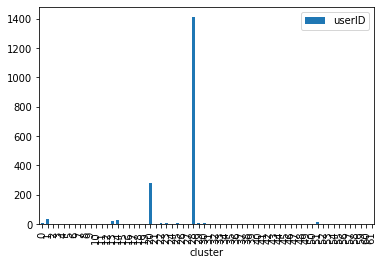

In [ ]:
pd.DataFrame(final_df[["userID", "cluster"]].groupby("cluster").count()).plot.bar()

As we can see from this distribution, there are particular clusters which contain the vast majority of users. We can only speculate as to why as we do not have an explainable clustering algorithm, but we do know that specific types of must are more popular than others, such as pop using which usually plays on the radio.
Using this knowledge, we can speculate that these populous clusters contain users who like more main stream music versus clusters that like more alternate music.

One thing to note, however, is that if some clusters don't have a lot of data points in them, they may make it harder for us to recommend a vast anmount of songs as we dont have much data to work with of what this cluster contains.

### Turn each cluster into one row

In [ ]:
cluster_representation_df = pd.DataFrame(columns=list(final_df.columns[1:]))

for cluster_num in tqdm(range(final_num_clusters)):

    rows_of_this_cluster = final_df[final_df["cluster"] == cluster_num]

    # remove the userID column
    rows_of_this_cluster.drop(columns=["userID"], inplace=True)

    # check if there are any users in this cluster
    if len(rows_of_this_cluster) > 0:

        # get the mean of each column for the data in this cluster
        aggregated_cluster_row = rows_of_this_cluster.groupby(['cluster']).mean()

        # add this aggregated row to a dataframe of all clusters
        cluster_representation_df = pd.concat([cluster_representation_df, aggregated_cluster_row], axis=0, ignore_index=True)

# reset the index to take the cluster out from being the index
cluster_representation_df = cluster_representation_df.reset_index().drop(columns=["cluster"]).rename(columns={"index": "cluster"})

In [ ]:
cluster_representation_df.head()

,cluster,!!!,!DISTAIN,!deladap,#####,#2 Orchestra,$lick,$lick feat. Six-Fo,(1962-1966),(Pre) Kingdom,(We Are) Performance,(hed) Planet Earth,(sic)monic,*NSYNC,+44,+\-,-123 min.,-OZ-,-t de sangre,...And The Earth Swarmed With Them,...And You Will Know Us by the Trail of Dead,.38 Special,.crrust,06 Children Of The Cross,08001,1-800-ZOMBIE,10 Years,10-20 БЕЗ ВЫХОДНЫХ,100 Bitches,1000names,100DEADRABBITS!!!,100blumen,100dBs,10cc,11.43,110,112,1125,12 Rounds,12 Stones,...,박정현,반야,배치기,백지영,비,빅뱅,샤이니,샤이니 (SHINee),서태지,소녀시대,소녀시대 ＆ 2PM,손담비,송지은,승리,시크릿,신화,아웃사이더,아이비,애프터 스쿨(After School),엠블랙(MBLAQ),원더걸스,윤하,이박사,이수영(여),이수영(여);,이정현,이효리,장근석,제빵왕,태양,티아라,현아,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ,ｂｏｏｇｉｅｍａｎ,ｂｏｒｎ,ｍａｃｈｉｎｅ
0,0,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.500000,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
1,1,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.482103,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
2,2,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.500000,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
3,3,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.500000,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5
4,4,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.500000,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5


---
---

# 6. Get user input

---
---

For the purpose of this example, we chose to take a single user from the given data to be our example user.
We used the music tastes of this user to base our recommendation on, matching this users listening habits to that of a cluster of people with similar musical interests.

In [ ]:
chosen_userID = 2 #@param {type:"slider", min:2, max:1891, step:1}

user_vector = pd.DataFrame(cluster_df.iloc[chosen_userID, ]).T

In [ ]:
user_vector

artistName,!!!,!DISTAIN,!deladap,#####,#2 Orchestra,$lick,$lick feat. Six-Fo,(1962-1966),(Pre) Kingdom,(We Are) Performance,(hed) Planet Earth,(sic)monic,*NSYNC,+44,+\-,-123 min.,-OZ-,-t de sangre,...And The Earth Swarmed With Them,...And You Will Know Us by the Trail of Dead,.38 Special,.crrust,06 Children Of The Cross,08001,1-800-ZOMBIE,10 Years,10-20 БЕЗ ВЫХОДНЫХ,100 Bitches,1000names,100DEADRABBITS!!!,100blumen,100dBs,10cc,11.43,110,112,1125,12 Rounds,12 Stones,120 Days,...,박정현,반야,배치기,백지영,비,빅뱅,샤이니,샤이니 (SHINee),서태지,소녀시대,소녀시대 ＆ 2PM,손담비,송지은,승리,시크릿,신화,아웃사이더,아이비,애프터 스쿨(After School),엠블랙(MBLAQ),원더걸스,윤하,이박사,이수영(여),이수영(여);,이정현,이효리,장근석,제빵왕,태양,티아라,현아,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ,ｂｏｏｇｉｅｍａｎ,ｂｏｒｎ,ｍａｃｈｉｎｅ
4,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,...,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5,-0.5


---
---

# 7. Get recommendation for this user

---
---

### Find the cluster(s) the user is most similar to

##### See how similar the user is to the representation of each cluster

In [ ]:
map_cluster_to_sim_score = {}
for cluster_num in tqdm(range(final_num_clusters)):
    
    cluster_vector = cluster_representation_df[cluster_representation_df["cluster"] == cluster_num].drop(columns=["cluster"])

    comparison_df = pd.concat([cluster_vector, user_vector], axis=0, ignore_index=True)
  
    # get the cosine similarity of the user generated row with the cluster row
    sim_mat = cosine_similarity(comparison_df)

    # store this similarity score
    map_cluster_to_sim_score[cluster_num] = sim_mat[0][1]

##### Find the cluster that is most similar 

In [ ]:
most_similar_cluster = []
highest_similarity = -1
for k, v in map_cluster_to_sim_score.items():
    if v == highest_similarity:
        most_similar_cluster.append(k)

    elif v > highest_similarity:
        most_similar_cluster = [k]
        highest_similarity = v

print("The most similar cluster is cluster '{}', this has a similarity score of '{}' with our users vector".format(most_similar_cluster, round(highest_similarity, 4)))

The most similar cluster is cluster '[28]', this has a similarity score of '0.9988' with our users vector


### Find the most popular songs in this most similar cluster(s)

##### Iterate through these similar clusters and put together a dataframe where each row is one of the simila clusters

In [ ]:
all_clusters = pd.DataFrame(columns=cluster_representation_df.columns)
for cluster_num in most_similar_cluster:
    all_clusters = pd.concat([all_clusters, pd.DataFrame(cluster_representation_df[cluster_representation_df["cluster"] == cluster_num])], axis=0, ignore_index=True)

In [ ]:
all_clusters

,cluster,!!!,!DISTAIN,!deladap,#####,#2 Orchestra,$lick,$lick feat. Six-Fo,(1962-1966),(Pre) Kingdom,(We Are) Performance,(hed) Planet Earth,(sic)monic,*NSYNC,+44,+\-,-123 min.,-OZ-,-t de sangre,...And The Earth Swarmed With Them,...And You Will Know Us by the Trail of Dead,.38 Special,.crrust,06 Children Of The Cross,08001,1-800-ZOMBIE,10 Years,10-20 БЕЗ ВЫХОДНЫХ,100 Bitches,1000names,100DEADRABBITS!!!,100blumen,100dBs,10cc,11.43,110,112,1125,12 Rounds,12 Stones,...,박정현,반야,배치기,백지영,비,빅뱅,샤이니,샤이니 (SHINee),서태지,소녀시대,소녀시대 ＆ 2PM,손담비,송지은,승리,시크릿,신화,아웃사이더,아이비,애프터 스쿨(After School),엠블랙(MBLAQ),원더걸스,윤하,이박사,이수영(여),이수영(여);,이정현,이효리,장근석,제빵왕,태양,티아라,현아,ＬｕＬｕ,ＭＡＮＮＥＱＵＩＮ,ＰＥＲＥＳＴＲＯＩＫＡ,ＲＥＤ,ＶａｎｅｓｓＡ,ｂｏｏｇｉｅｍａｎ,ｂｏｒｎ,ｍａｃｈｉｎｅ
0,28,-0.49904,-0.499336,-0.499774,-0.497593,-0.499759,-0.5,-0.5,-0.499776,-0.499786,-0.499786,-0.497999,-0.49978,-0.49715,-0.495407,-0.4996,-0.499773,-0.498975,-0.49971,-0.499773,-0.496236,-0.499483,-0.499324,-0.499782,-0.499762,-0.499778,-0.498892,-0.499762,-0.499286,-0.499771,-0.499212,-0.49971,-0.499697,-0.498486,-0.499774,-0.499786,-0.499745,-0.499588,-0.499765,-0.496197,...,-0.499739,-0.49952,-0.499768,-0.499186,-0.499784,-0.5,-0.499644,-0.499729,-0.499746,-0.497861,-0.5,-0.499655,-0.499698,-0.5,-0.49967,-0.499452,-0.49966,-0.499781,-0.5,-0.5,-0.5,-0.4991,-0.499687,-0.499777,-0.499785,-0.499773,-0.499485,-0.5,-0.5,-0.499645,-0.498881,-0.5,-0.499393,-0.49968,-0.499716,-0.499716,-0.499377,-0.499715,-0.499355,-0.499534


##### Map each song to the maximum weighting it has in this created dataframe

In [ ]:
map_col_to_max_val = {}
for col in all_clusters.columns[1:]:
    map_col_to_max_val[col] = all_clusters[col].max()

##### Get a list of the ordered recommendation of these songs from this dictionary

In [ ]:
list_of_songs = []
list_of_weights = []
for song, weight in sorted(map_col_to_max_val.items(), key=lambda item: item[1])[::-1]:
    list_of_songs.append(song)
    list_of_weights.append(weight + 0.5)

---
---

# 8. Output Recommendation

---
---

### Create a colour for each of the artist genres

To make visualisation easier, we assign a random colour to each genre.

In [ ]:
def random_colour():
    return "#" + "".join([random.choice("0123456789ABCDEF") for j in range(6)])

In [ ]:
# Assign colours to each genre
unique_genres = artists["genre"].unique()
colours  = [random_colour() for _ in range(len(unique_genres))]

genre_colours = pd.DataFrame({
    "genre": unique_genres,
    "colour": colours
})

genre_colours

,genre,colour
0,None,#38126A
1,dark wave,#FD2359
2,black metal,#F8723D
3,gothic black metal,#9099BA
4,alternative metal,#D0BB24
...,...,...
2044,armenian folk,#40027D
2045,kurdish pop,#1765C1
2046,musica tradicional cubana,#D8398B
2047,jazz boom bap,#19537E


### Plot these recommended artists

In [ ]:
# Template for plotting
template = dict(
  layout=go.Layout(
    title=dict(
      x=0.5,
      xanchor="center"
    )
  )
)

In [ ]:
def plot_artists(names_list, scores_list, num_recommendations):

  if num_recommendations > len(names_list:):
      names = names_list
      scores = scores_list
  
  else:
      names = names_list[:num_recommendations]
      scores = scores_list[:num_recommendations]

  genres = artists.set_index("artistName").loc[names, "genre"].tolist()
  colours = genre_colours.set_index("genre").loc[genres, "colour"].tolist()

  data = pd.DataFrame({"name": names, "weight": scores, "color": colours, "genre": genres})
  fig = go.Figure(go.Bar(dict(
    x=data["name"],
    y=data["weight"],
    marker=dict(
        color=data["color"]
    ),
    hovertemplate=(
      "Artist: %{x}<br>"
      "Genre: %{text[0]}<br>"
      "Predicted value: %{y:,.3f} <br>"
    ),
    text=data[["genre"]],
    name=""
  )), layout=dict(
      template=template,
      yaxis=dict(title="Predicted Value", zeroline=True),
      title=dict(text="Artist Recommendations for the Given User"),
  ))

  fig.show()

The below plot shows an ordered list of the recommended artist for the chosen user. This interactive chart allows you to hover over the bars in the plot for more information.
You can specify how many recommendations you are given also

In [ ]:
num_recommendations = 50

In [ ]:
plot_artists(list_of_songs, list_of_weights, num_recommendations)